In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as ani
import matplotlib.cm as cm  

In [35]:
#constants of nature

mu0 = 4 * np.pi * 1e-7
e0 = 8.85e-12
c = np.sqrt(1 / (mu0 * e0))
k = 1 / (4 * np.pi * e0)
print("the speed of light is:", c)
c = 0.3

dt = 0.0007

the speed of light is: 299863380.46612763


In [36]:
t0 = 0
t1 = 40
timesteps = np.arange(t0, t1, dt)
print(timesteps.shape)

(57143,)


In [37]:
def external_force_func(E0,omega,timesteps):
    return (E0 * np.sin(omega * timesteps))

E0 = 0.03 #0.02
omega = np.sqrt(2) 

external_force_arr = external_force_func(E0,omega,timesteps)
    

In [38]:
class Particle:
    
    def __init__(self, mass=1, charge=1, pos=np.array([0.0,0.0,0.0]), vel=np.array([0.0,0.0,0.0]), acc=np.array([0.0,0.0,0.0])):
        self.mass = mass
        self.charge = charge
        self.pos = pos
        self.vel = vel
        self.acc = acc

class Dipole:
    
    def __init__(self, timesteps, distance=1, charge=1):
        self.distance = distance
        self.charge = charge
        self.mass = 1
        self.particle1 = Particle(mass=self.mass, charge=self.charge, pos=np.array([-distance/2, 0,0]))
        self.particle2 = Particle(mass=self.mass, charge=-self.charge, pos=np.array([distance/2, 0,0]))
        self.dipole_moment = self.charge * np.array([self.distance, 0, 0])
        self.force = 0
        self.timesteps = timesteps
        self.pos1 = np.zeros((self.timesteps.size, 3))
        self.pos2 = np.zeros((self.timesteps.size, 3))
        self.xs = np.zeros(self.timesteps.shape)
        self.xs2 = np.zeros(self.timesteps.shape)
        self.k = 1
        
    def update(self, external_force):
        r = self.particle2.pos - self.particle1.pos
        
        spring_force = self.k * (np.linalg.norm(r) - self.distance) * (r / np.linalg.norm(r))
        force = spring_force + external_force * self.charge
        
        self.particle1.acc = force / self.particle1.mass
        self.particle2.acc = -force / self.particle2.mass
        self.particle1.vel = self.particle1.vel + self.particle1.acc * dt
        self.particle2.vel = self.particle2.vel + self.particle2.acc * dt
        
        self.particle1.pos += self.particle1.vel * dt
        self.particle2.pos += self.particle2.vel * dt
        
#         print(self.particle1.vel + self.particle1.acc * dt)

#         print(self.particle1.pos)
#         print(self.particle2.pos)
        
    def calc_trajectory(self):
        
        for i, time in enumerate(self.timesteps):
            self.pos1[i] = self.particle1.pos
            self.pos2[i] = self.particle2.pos
            self.xs[i] = self.particle1.pos[0]
            self.xs2[i] = self.particle2.pos[0]
            
#             print(i)
#             print(time)
            
            external_force = np.array([external_force_arr[i], 0, 0])
            
            self.update(external_force)
            
        return self.pos1, self.pos2
        

<IPython.core.display.Javascript object>


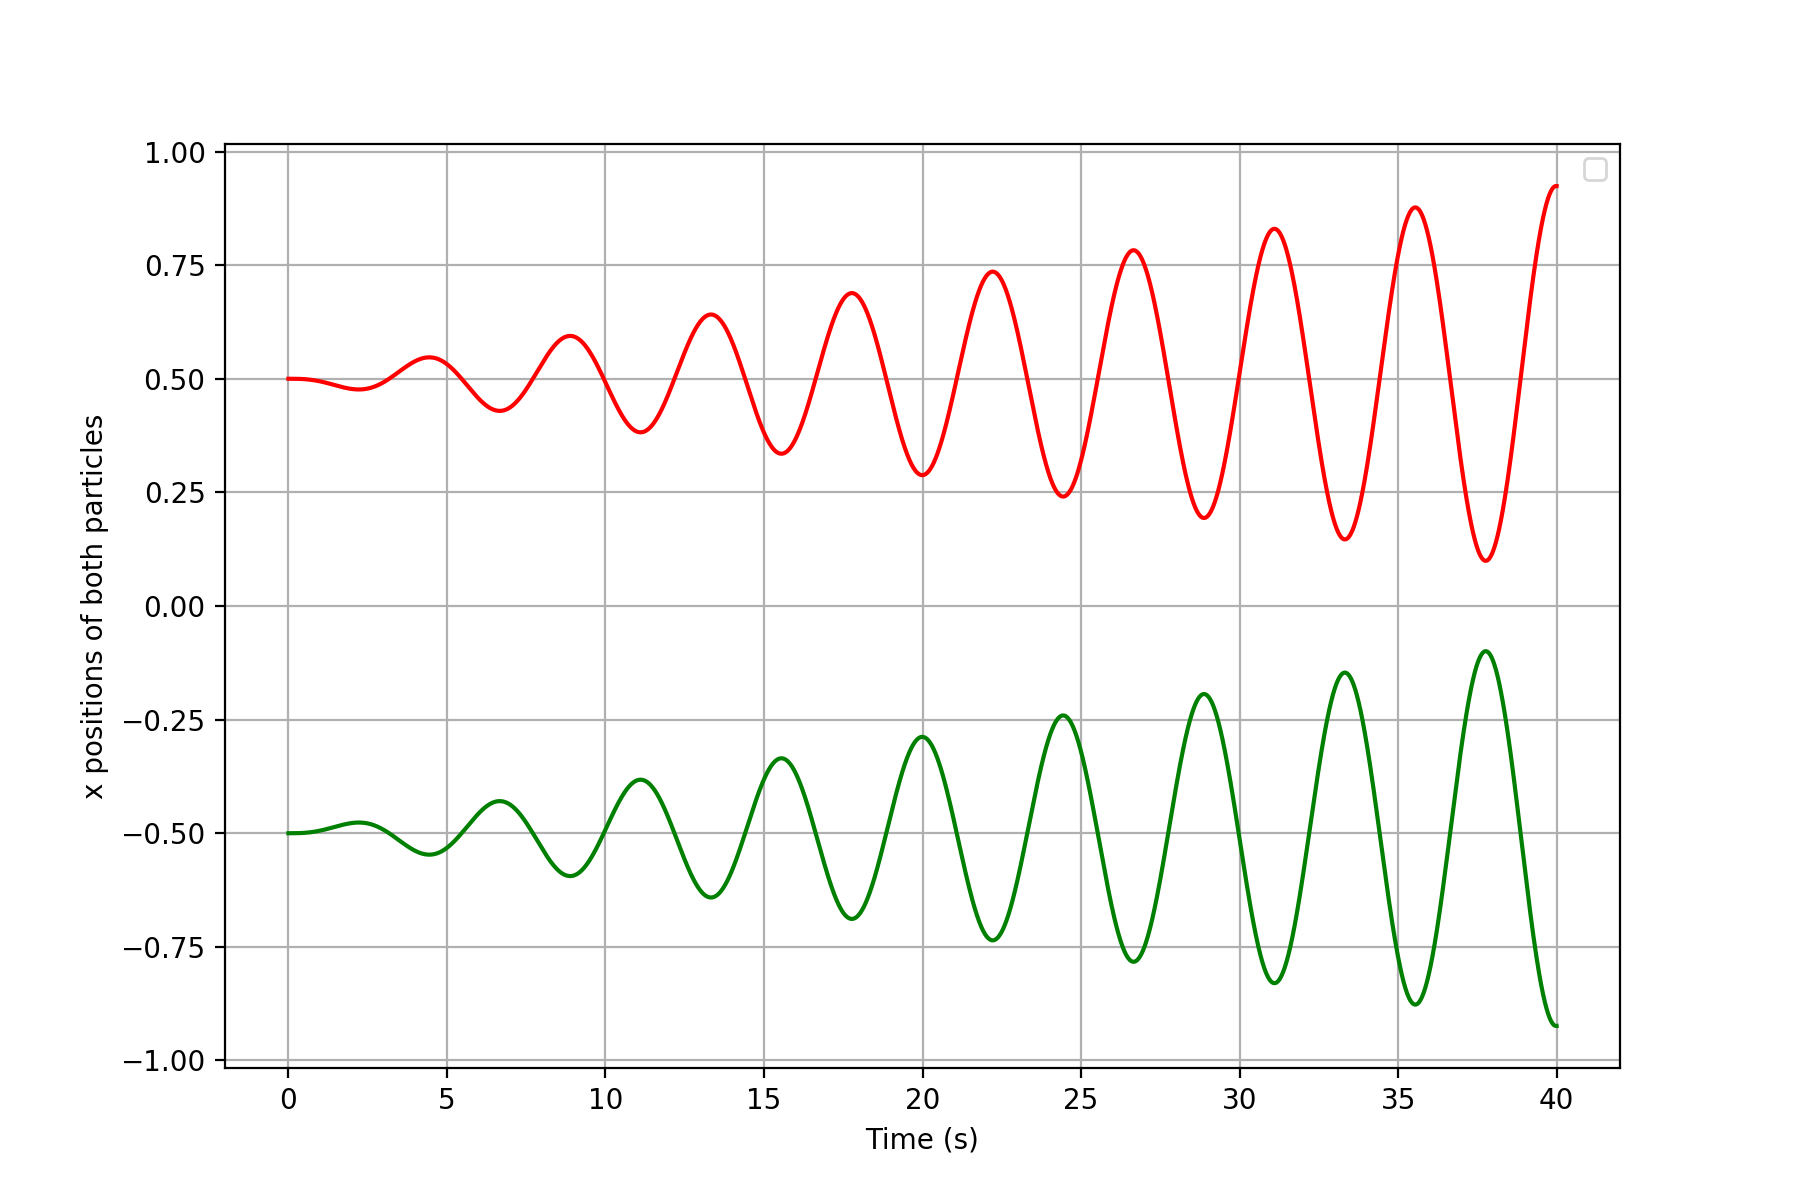

No handles with labels found to put in legend.


0.9241150414230235


In [39]:
dipole = Dipole(timesteps)

pos1, pos2 = dipole.calc_trajectory()
# print(timesteps.shape)
# print(pos1)



fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, pos1[:, 0], 'g')
ax1.plot(timesteps, pos2[:, 0], 'r')
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("x positions of both particles")
ax1.legend()

print(np.amax(pos2))

# print(pos1[:, 0])

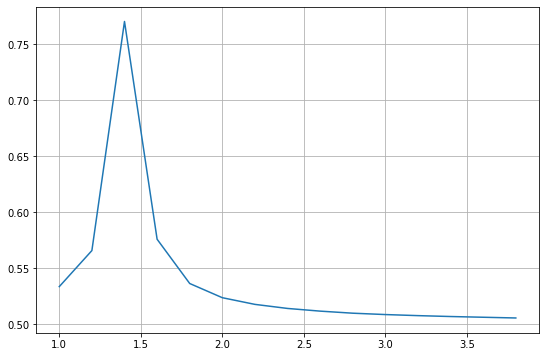

In [7]:
omega_arr = np.arange(1,4,0.2)
E0 = 0.02
plot_store = np.zeros(np.shape(omega_arr))
for i in range(np.size(omega_arr)):
    external_force_arr = external_force_func(E0,omega_arr[i],timesteps)
    dipole_arr = Dipole(timesteps)
    posA,posB = dipole_arr.calc_trajectory()    
    plot_store[i] = np.amax(posB)
    #print(np.amax(posB))
    

    
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(omega_arr,plot_store)
ax1.grid()

In [40]:
def binary_search(array, value):
    low = 0
    high = array.size - 1
    midpoint = int((high - low) / 2)
    n = 0
    
    if value > array[high]:
        return -1
    
    while(low <= high and n < array.size):
        n+=1
        midpoint = int((low + high) / 2)
        if array[midpoint] == value:
            return midpoint
        elif array[midpoint] > value:
            high = midpoint - 1
        elif array[midpoint] < value:
            low = midpoint + 1
    return midpoint


In [41]:
class point_in_space():
    
    def __init__(self, x, y, z, timesteps):
        self.xyz = np.array([x, y, z])
        self.electric_field = np.zeros((timesteps.size, 3))
        self.electric_field_1 = np.zeros((timesteps.size, 3))
        self.electric_field_2 = np.zeros((timesteps.size, 3))
        self.first_index = 0
        self.first_index1 = 0
        self.first_index2 = 0
        self.iteration_flag = False
        
    def reset_electric_field(self):
        self.electric_field_1 = np.zeros((timesteps.size, 3))
        self.electric_field_2 = np.zeros((timesteps.size, 3))


In [42]:
indices = np.zeros(timesteps.shape)
def populate_electric_field_array(pos1, pos2, point_in_space, time, i):
    r1 = point_in_space.xyz - pos1
    r2 = point_in_space.xyz - pos2
    
    time1 = time + np.linalg.norm(r1) / c
    time2 = time + np.linalg.norm(r2) / c
    
    index1 = binary_search(timesteps, time1)
    index2 = binary_search(timesteps, time2)
    
    indices[i] = index1
    
    r_mag1 = np.linalg.norm(r1)
    r_mag2 = np.linalg.norm(r2)
    
    Ex1 = dipole.charge * (r1[0]*r_mag1**-3)
    Ey1 = dipole.charge * (r1[1]*r_mag1**-3)
    Ez1 = dipole.charge * (r1[2]*r_mag1**-3)
    
    Ex2 = -dipole.charge * (r2[0]*r_mag2**-3)
    Ey2 = -dipole.charge * (r2[1]*r_mag2**-3)
    Ez2 = -dipole.charge * (r2[2]*r_mag2**-3)
    
    if index1 != -1:
        point_in_space.electric_field_1[index1] = np.array([Ex1, Ey1, Ez1])
    if index2 != -1:
        point_in_space.electric_field_2[index2] = np.array([Ex2, Ey2, Ez2])
    
    if index1 == -1 and index2 == -1:
        point_in_space.iteration_flag = True
        
    if(i == 0):
        point_in_space.first_index1 = index1
        point_in_space.first_index2 = index2
        point_in_space.electric_field_1[:index1] = np.array([Ex1, Ey1, Ez1])
        point_in_space.electric_field_2[:index2] = np.array([Ex2, Ey2, Ez2])

p2 = point_in_space(-.75, -.5, 0, timesteps)
populate_electric_field_array(pos1[0], pos2[0], p2, 0, 0)
print(p2.first_index1)

2662


In [43]:
epsilon = 0.002
def relax(arr, relax_mask):
    keep_same = arr[relax_mask]
    
    

In [44]:
def calculate_electric_field(point_in_space):
    for i, t in enumerate(timesteps):
        populate_electric_field_array(pos1[i], pos2[i], point_in_space, t, i)
        if point_in_space.iteration_flag:
            break
    point_in_space.electric_field = point_in_space.electric_field_1 + point_in_space.electric_field_2
    point_in_space.first_index = np.max(point_in_space.first_index1 + point_in_space.first_index2)

In [45]:
p1 = point_in_space(0, 0.8, 0, timesteps)
p1.reset_electric_field()
calculate_electric_field(p1)
mask = np.where((np.abs(p1.electric_field[:, 0]) < 50) & (np.abs(p1.electric_field_1[:, 0]) > 0.01) & (np.abs(p1.electric_field_2[:, 0]) > 0.01))

<IPython.core.display.Javascript object>


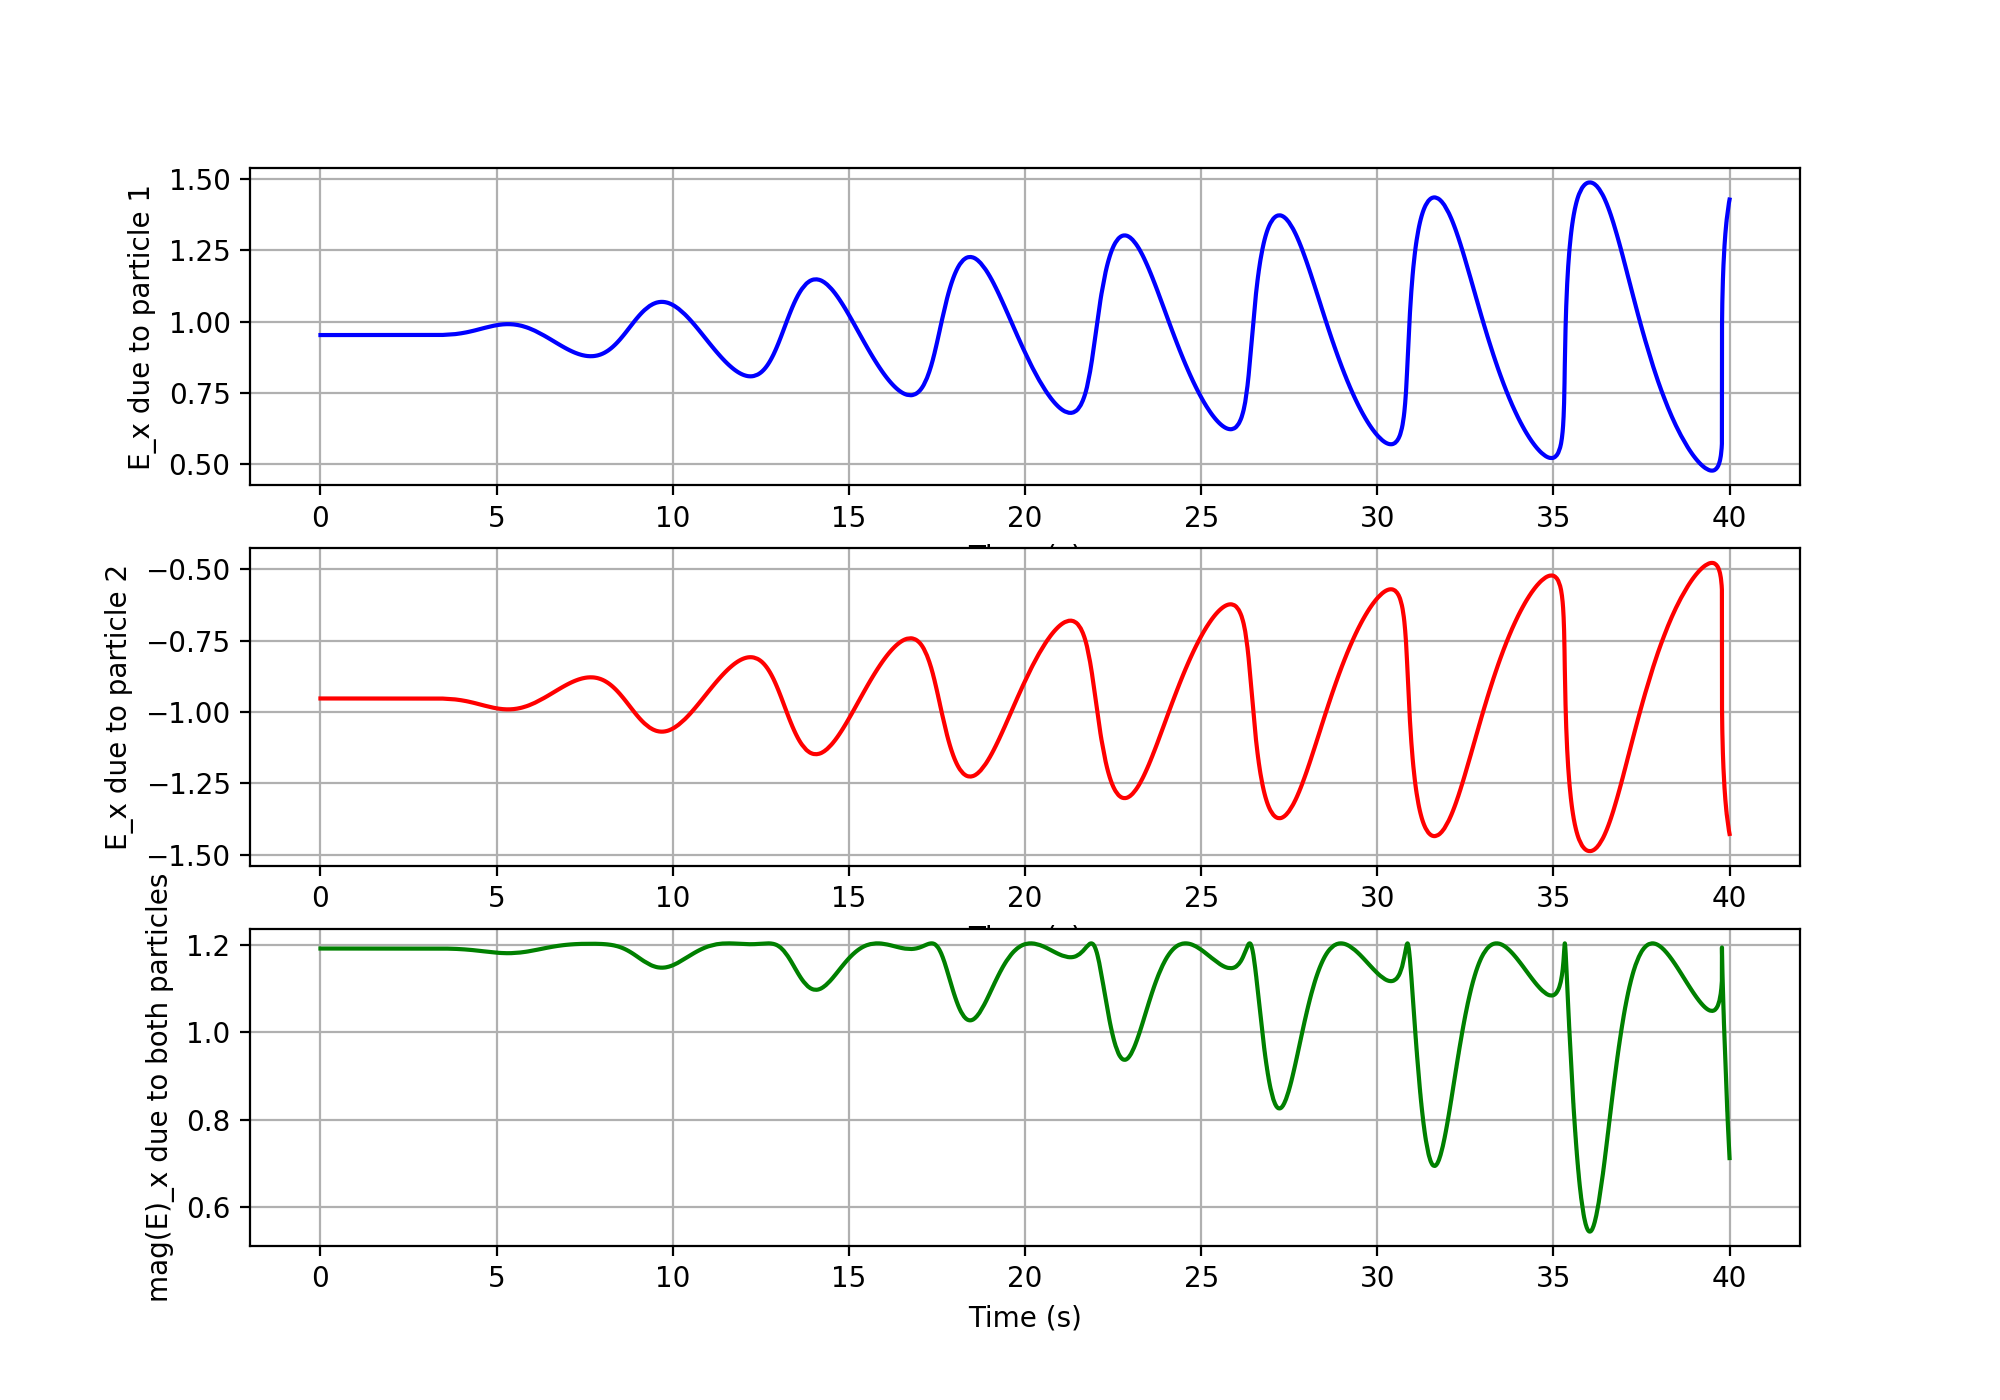

In [46]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,7))
ax1.plot(timesteps[:][mask], p1.electric_field_1[:, 1][mask], 'b-')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")
#ax1.legend()


ax2.plot(timesteps[:][mask], p1.electric_field_2[:, 1][mask], 'r-')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("E_x due to particle 2")


ax3.plot(timesteps[mask], p1.electric_field[:, 0][mask], 'g-')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_x due to both particles")

ax1.grid()
ax2.grid()
ax3.grid()





<IPython.core.display.Javascript object>


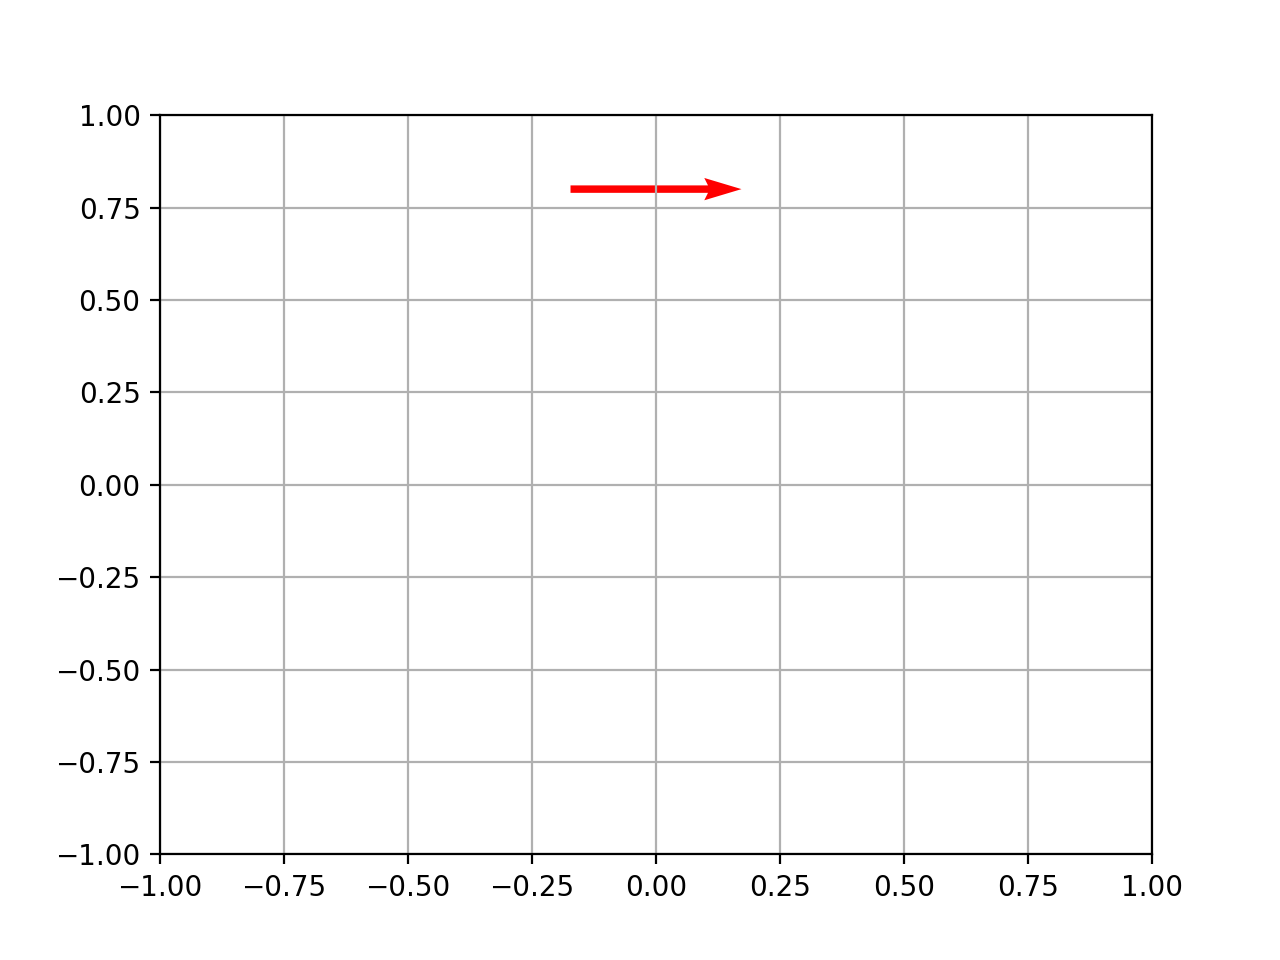

2096
1.19010536816212 0.0


In [27]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
index = p1.first_index
print(index)
frame_num = int(p1.electric_field[mask].size / 3 - p1.first_index)


Ex = p1.electric_field[mask][index, 0]
Ey = p1.electric_field[mask][index, 1]
speed_factor = 10
print(Ex, Ey)
# print(timesteps.size)
plt.grid()

E_changing_plot = ax.quiver(p1.xyz[0], p1.xyz[1], 
                   Ex, Ey, 
                   units='inches',pivot='mid',color='r', scale=7)


def plot_point_in_space(i):

    scale_factor = 5
    
    
    Ex = p1.electric_field[mask][speed_factor * i + p1.first_index, 0]*scale_factor
    Ey = p1.electric_field[mask][speed_factor * i + p1.first_index, 1]*scale_factor 
    
    E_changing_plot.set_UVC(Ex, Ey)
    
    return E_changing_plot,

anim = ani.FuncAnimation(fig, plot_point_in_space,
                               frames=frame_num, interval=1, blit=True)
# print(np.linalg.norm([Ex, Ey]))
plt.show()

In [15]:
def calc_electric_field(dipole, point):
    dif1 = point - dipole.particle1.pos
    dif2 = point - dipole.particle2.pos
    
    r_mag1 = np.linalg.norm(dif1)
    r_mag2 = np.linalg.norm(dif2)
    
    Ex = dipole.charge * (dif1[0]*r_mag1**-3 - dif2[0]*r_mag2**-3)
    Ey = dipole.charge * (dif1[1]*r_mag1**-3 - dif2[1]*r_mag2**-3)
    Ez = dipole.charge * (dif1[2]*r_mag1**-3 - dif2[2]*r_mag2**-3)
#     print(dif1)
    
    return np.array([Ex, Ey, Ez])

print(calc_electric_field(dipole, [-0.75, -0.5, 0]))

[ 1.4866024  -3.27589721  0.        ]


[-0.91648575 -2.66751935  0.        ]


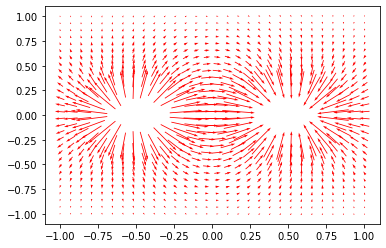

In [16]:
dipole = Dipole(timesteps)

pos1, pos2 = dipole.calc_trajectory()

Nsteps = 30
grid_min = -1
grid_max = 1
# print(np.array([x[0], y[0]]))
print(calc_electric_field(dipole, [-0.75, -0.5, 0]))

x, y = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))
E = calc_electric_field(dipole, [x, y, 0])

magEfield = np.sqrt(E[0]**2 + E[1]**2 + E[2]**2)
maxMagEfield = np.max(magEfield)

mask_efield = np.where(magEfield < maxMagEfield * 0.02)

Qplot = plt.quiver(x[mask_efield], y[mask_efield], 
                   E[0][mask_efield], E[1][mask_efield], 
                   units='inches',pivot='mid',color='r', scale=25)

In [26]:
new_point = point_in_space(0.5, 5, 0, timesteps)
new_point.reset_electric_field()
calculate_electric_field(new_point)
mask = np.where((np.abs(new_point.electric_field[:, 0]) < 50) & (np.abs(new_point.electric_field_1[:, 0]) != 0) & (np.abs(new_point.electric_field_2[:, 0]) != 0))

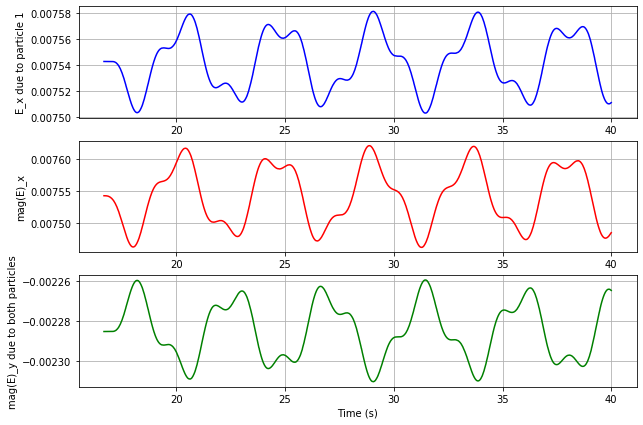

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,7))
ax1.plot(timesteps[:][mask], new_point.electric_field_1[:, 0][mask], 'b-')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")
#ax1.legend()


ax2.plot(timesteps[:][mask], new_point.electric_field[:, 0][mask], 'r-')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("mag(E)_x")


ax3.plot(timesteps[mask], new_point.electric_field[:, 1][mask], 'g-')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_y due to both particles")

ax1.grid()
ax2.grid()
ax3.grid()



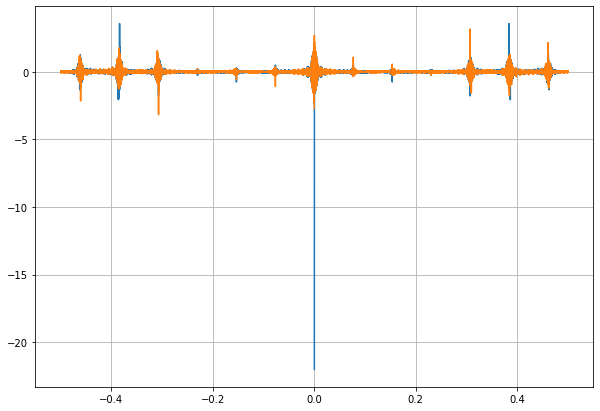

In [19]:

fig, (ax1) = plt.subplots(1, figsize=(10,7))
sp = np.fft.fft( new_point.electric_field[:, 1])
freq = np.fft.fftfreq(timesteps.shape[-1])
ax1.plot(freq, sp.real, freq, sp.imag)

ax1.grid()